# 非线性函数拟合

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

### 目标函数
$$f(x)=2x\cos{(2x)}(x^2+7x+1)$$
$$f^{\prime}(x)=(6x^2+28x+2)\cos{(2x)}-(4x^3+28x^2+4x)\sin{(2x)}$$

In [3]:
target_func = lambda x: 2 * x * np.cos(2 * x) * (x * x + 7 * x + 1)
target_func_derivative1 = lambda x: (6*x*x + 28*x + 2) * np.cos(2*x) - (4*x*x*x + 28*x*x + 4*x) * np.sin(2*x) # 目标函数的一阶导数

### 配置类

In [4]:
class Config:
    range = (-10, 10)
    noise_mean = 0 # 噪声正态分布均值
    noise_std = 0.1 # 噪声正态分布标准差
    train_dataset_sample_num = 1000000
    batch_size = 1024
    lr = 1e-19
    num_epochs = 100
    fitting_order = 15 # 多项式拟合函数的次数
    loss_ratio = [0, 1]
    lr_list = []


def gen_lr_list():
    base_lr = 0.01
    for i in range(Config.fitting_order + 1):
        Config.lr_list.append(base_lr * math.pow(10, i))
    # Config.lr_list.reverse()
        # if i < 5:
        #     Config.lr_list.append(base_lr)
        # elif i < 10:
        #     Config.lr_list.append(base_lr * 5)
        # elif i < 15:
        #     Config.lr_list.append(base_lr * 10)
        # elif i < 20:
        #     Config.lr_list.append(base_lr * 20)
        # elif i < 25:
        #     Config.lr_list.append(base_lr * 30)
        # elif i < 35:
        #     Config.lr_list.append(base_lr * 50)
        # elif i < 2000:
        #     Config.lr_list.append(base_lr * 100)

gen_lr_list()

### 绘制目标函数图像

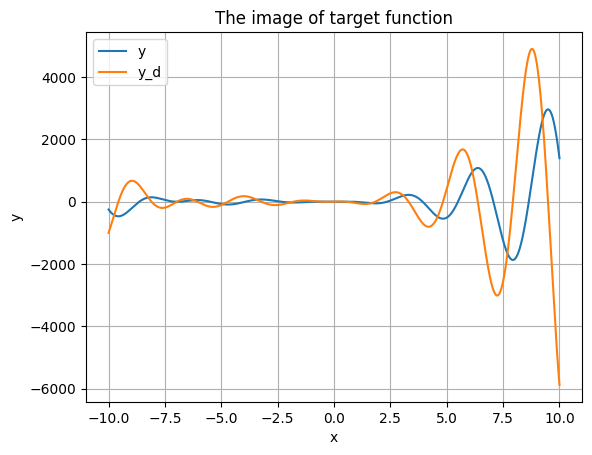

In [5]:
def paint_target_func():
    X = np.linspace(Config.range[0], Config.range[1], 2000)
    Y = target_func(X)
    Y_d = target_func_derivative1(X)
    plt.plot(X, Y, label="y")
    plt.plot(X, Y_d, label="y_d")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title('The image of target function')
    plt.grid(True)
    plt.show()

paint_target_func()

### 生成数据集

In [6]:
def generate_dataset(num_samples: int, is_train: bool):
    X = np.random.uniform(Config.range[0], Config.range[1], num_samples)
    noise = None
    if is_train:
        noise = np.random.normal(Config.noise_mean, Config.noise_std, num_samples)
    else:
        noise = 0
    Y = target_func(X) + noise
    # Y = target_func(X)
    Y_d = target_func_derivative1(X)
    # X = X / Config.range[1]
    return (X, Y, Y_d)

train_X, train_Y, train_Y_d = generate_dataset(Config.train_dataset_sample_num, True)

### 读取数据集

In [7]:
def data_iter(X, Y, Y_d, batch_size, is_train: bool):
    num_samples = len(X)
    indices = np.arange(num_samples) 
    # 如果是训练模式，则打乱读取样本数据
    if is_train:
        np.random.shuffle(indices)
    for i in range(0, num_samples, batch_size):
        batch_indices = indices[i: min(i+batch_size, num_samples)]
        yield X[batch_indices], Y[batch_indices], Y_d[batch_indices]

### 线性模型（前向传播）

In [8]:
def linear_net(x, w):
    func_order = len(w) - 1 # 函数次数
    x = np.repeat(x, func_order + 1).reshape((-1, func_order + 1)) # 将x改为[[x_1, ..., x_1], ..., [x_n, ..., x_n]]
    w = np.tile(w, (len(x), 1)) # 将w改为[[w_1, ..., w_m], ..., [w_1, ..., w_m]]
    order_list = np.arange(0, func_order + 1) # x的次数列表
    grad = np.power(x, order_list)
    output = np.nansum(w * grad, axis=1)
    coefficient = np.arange(1, func_order + 1)
    coefficient = np.tile(coefficient, (len(x), 1))
    grad_d = grad[:, :-1] * coefficient
    output_d = np.nansum(w[:, 1:] * grad_d, axis=1)
    grad_d = np.hstack((np.zeros((len(x), 1)), grad_d[:, :]))
    return output, output_d, grad, grad_d # 计算 w_m * x^n + ... + w2 * x + w-1

# 测试，以下参数表示函数为：x^2 + 4x + 4
x = np.array([0, 1, 2])
w = np.array([4, 4, 1])
print(linear_net(x, w))
print(x)
print(w)

(array([ 4,  9, 16]), array([4, 6, 8]), array([[1, 0, 0],
       [1, 1, 1],
       [1, 2, 4]]), array([[0., 1., 0.],
       [0., 1., 2.],
       [0., 1., 4.]]))
[0 1 2]
[4 4 1]


### 损失函数

In [9]:
def loss(y_hat, y, y_d_hat, y_d):
    loss = Config.loss_ratio[0] * np.power(y_hat-y, 2) / 2 + Config.loss_ratio[1] * np.power(y_d_hat-y_d, 2) / 2
    return loss

### 初始化$w$

In [10]:
weight = np.random.normal(0, 1, Config.fitting_order + 1)

### 训练过程

In [11]:
def train():
    loss_list = []
    weight = np.random.normal(0, 10, Config.fitting_order + 1)
    mask = np.zeros(Config.fitting_order + 1)
    mask[0:3] = 1
    mask_i = 3
    for e in range(Config.num_epochs):
        for i, (X, Y, Y_d) in enumerate(data_iter(train_X, train_Y, train_Y_d, Config.batch_size, True)):
            output, output_d, grad, grad_d = linear_net(X, weight)
            # print(f"x****************{grad_d}")
            l = loss(output, Y, output_d, Y_d)
            loss_list.append(l.mean())
            grad_w = (Y - output).reshape(-1, 1) * grad * Config.loss_ratio[0] + (Y_d - output_d).reshape(-1, 1) * grad_d * Config.loss_ratio[1]
            # print(grad_w.mean(axis=0))
            delta = Config.lr * grad_w.mean(axis=0)
            # print(delta)
            # print(weight)
            for i in range(len(delta)):
                if delta[i] > 1e3:
                    delta[i] = 1e3
                if delta[i] < -1e3:
                    delta[i] = -1e3
            delta = delta * mask
            weight = weight + delta
            
            
            print(weight)
            # if (i + 1) % 100 == 0:
            print(f'Epoch {e} Mask {mask_i} Loss{l.mean()}')
        if e%2 == 0:
            mask[mask_i] = 1
            mask[mask_i-3] = 0
            mask_i += 1

            # print(f'Epoch [{e+1}/{Config.num_epochs}], Step [{i+1}/{math.ceil(len(train_X)/Config.batch_size)}], Loss: {l.mean()}, Weight: {weight}')
            
    
    # 绘制训练过程中的损失函数
    plt.plot(np.arange(len(loss_list)), loss_list)
    plt.xlabel('i')
    plt.ylabel('loss')
    plt.title('The loss of train process')
    plt.grid(True)
    plt.show()
    return weight

# res = train()
# print(res)
# weight = res

In [12]:
def train():
    global weight
    loss_list = []
    for e in range(Config.num_epochs):
        for i, (X, Y, Y_d) in enumerate(data_iter(train_X, train_Y, train_Y_d, Config.batch_size, True)):
            output, output_d, grad, grad_d = linear_net(X, weight)
            # print(f"x****************{grad_d}")
            l = loss(output, Y, output_d, Y_d)
            grad_w = (Y - output).reshape(-1, 1) * grad * Config.loss_ratio[0] + (Y_d - output_d).reshape(-1, 1) * grad_d * Config.loss_ratio[1]
            # print(grad_w.mean(axis=0))
            delta = Config.lr * grad_w.mean(axis=0)
            # print(delta)
            # print(weight)
            for i in range(len(delta)):
                if delta[i] > 1e3:
                    delta[i] = 1e3
                if delta[i] < -1e3:
                    delta[i] = -1e3
            weight = weight + delta
            print(weight)
            # if (i + 1) % 100 == 0:
            print(f'${e} Loss{l.mean()}')
            # print(f'Epoch [{e+1}/{Config.num_epochs}], Step [{i+1}/{math.ceil(len(train_X)/Config.batch_size)}], Loss: {l.mean()}, Weight: {weight}')
            loss_list.append(l.mean())
    
    # 绘制训练过程中的损失函数
    plt.plot(np.arange(len(loss_list)), loss_list)
    plt.xlabel('i')
    plt.ylabel('loss')
    plt.title('The loss of train process')
    plt.grid(True)
    plt.show()

train()

[ 1.29248963e+00  6.87286256e-02  5.77119534e-01  3.98593600e-01
 -8.12108516e-01 -7.05540281e-01  1.26718620e+00 -6.55069637e+00
  3.36218827e+01 -7.30103264e+02  9.99718822e+02 -1.00057285e+03
  1.00031854e+03 -9.99488786e+02  9.99489178e+02 -9.99898397e+02]
$0 Loss6.404329707478703e+26
[ 1.29248963e+00  7.85561837e-02  5.92318269e-01  2.99553809e+00
  2.57294925e+00  3.85612636e+02  5.45842256e+02  9.93449304e+02
  1.03362188e+03  2.69896736e+02  1.99971882e+03 -5.72845519e-01
  2.00031854e+03  5.11213778e-01  1.99948918e+03  1.01603250e-01]
$0 Loss3.6980468662573403e+34
[ 1.29248963e+00  7.84404141e-02  5.52588760e-01  2.96436980e+00
 -4.49932602e+00  3.80946146e+02 -4.11138894e+02  4.07685861e+02
  3.36218827e+01 -7.30103264e+02  9.99718822e+02 -1.00057285e+03
  1.00031854e+03 -9.99488786e+02  9.99489178e+02 -9.99898397e+02]
$0 Loss1.6297687107622622e+33
[ 1.29248963e+00  9.03129728e-02  5.35866095e-01  6.15639075e+00
 -7.38590235e+00  8.63656674e+02 -7.92791650e+02  1.40768586e+0

KeyboardInterrupt: 

### 测试过程

15
[-32.3792594, -94.1341025, -0.9773026780000001, 9.088910940000002, 0.6522291410000001, -0.11011114100000004, -0.011430660900000006, -0.0016375804000000006, -0.00011764382000000006, -1.972955140000001e-06, 1.388778420000001e-07, 1.612603080000001e-07, 1.4451887200000008e-08, 2.4844533900000017e-09, 1.8995729400000014e-10, 1.8690248000000016e-11, 1.259658440000001e-12, -2.3948229600000024e-14, -3.597205660000004e-15, -3.5761897600000034e-15, -2.697231300000003e-16]


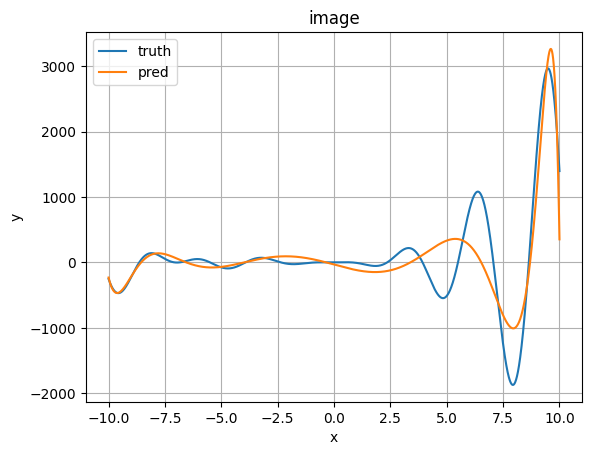

In [24]:

def test():
    X = np.linspace(Config.range[0], Config.range[1], 20000)
    Y = target_func(X)
    # global weight
    # weight = np.load('text.npy')
    print(Config.fitting_order)
    weight = [-3.23792594e+01, -9.41341025e+02, -9.77302678e+01,  9.08891094e+03,
    6.52229141e+03, -1.10111141e+04, -1.14306609e+04, -1.63758040e+04,
    -1.17643820e+04, -1.97295514e+03,  1.38877842e+03,  1.61260308e+04,
    1.44518872e+04,  2.48445339e+04,  1.89957294e+04,  1.86902480e+04,
    1.25965844e+04, -2.39482296e+03, -3.59720566e+03, -3.57618976e+04, -2.69723130e+04]
    for i in range(len(weight)):
        weight[i] = weight[i] * math.pow(0.1, i)
        # if weight[i] < 1e-10 and weight[i] > -1e-10:
        #     weight[i] = 0

    print(weight)
    Y_hat, _, _, _ = linear_net(X, weight)
    plt.plot(X, Y, label="truth")
    plt.plot(X, Y_hat, label="pred")
    # plt.plot(X, Y_hat * (2 * Config.range[1] ** 3 + 14 * Config.range[1]**2 + 2 * Config.range[1]), label="pred")

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('image')
    plt.legend()
    plt.grid(True)
    plt.show()

test()